This notebook aims to clusturise departments in metropolitan France using crimes and misdemeanors data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [143]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")
security_df['code_dep'] = security_df['code_dep'].astype(str)
col_a_supprimer = ['971', '972', '973', '974', 'France_Métro']
security_df = security_df[~security_df['code_dep'].isin(col_a_supprimer)]

In [144]:
security_df_selected_columns = security_df[['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population", "code_dep"]]

In [145]:
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()

In [146]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

colonnes_pca = ['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population"]


donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)

# Application de la PCA
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)

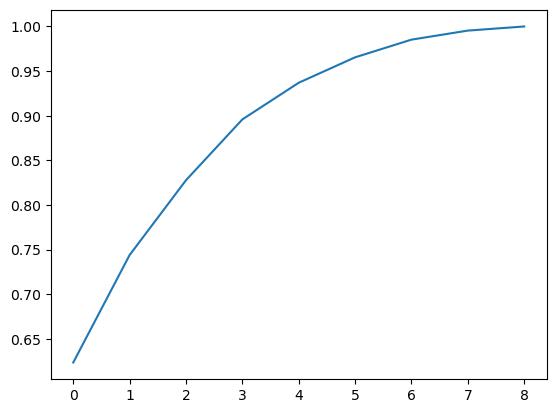

In [95]:
plt.plot(np.cumsum(resultats_pca.explained_variance_ratio_))

In [147]:
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']

# best_nb_cluster = tools.best_nb_cluster(
#         resultats_pca_df,
#         ['PCA1', 'PCA2', 'PCA3'],
#         2,
#         44,
#         True,
#         "Silouhette score evolution"
# )

In [148]:
from sklearn.cluster import KMeans
                 
feature_columns = ['PCA1', 'PCA2', 'PCA3']
X = resultats_pca_df[feature_columns].values

wss_values = []

k_values = range(2, 30)

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     wss_values.append(kmeans.inertia_)
# 
# # Plot the curve of WSS versus the number of clusters (k)
# plt.plot(k_values, wss_values, marker='o')
# plt.title('Elbow Method For Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Within-Cluster Sum of Squares (WSS)')
# plt.show()

In [149]:
labels = tools.clustering(resultats_pca_df,
                 ['PCA1', 'PCA2', 'PCA3'],
                 5)

In [150]:
resultats_pca_df['Cluster'] = labels

In [151]:
departements_geojson_name = 'departements.geojson'
gdf_departements = gpd.read_file(departements_geojson_name)

# Fusionner seulement la colonne "Cluster" dans le GeoDataFrame
gdf_departements['Cluster'] = gdf_departements['code'].astype(str).map(resultats_pca_df.set_index('dept')['Cluster'])

In [152]:
print(resultats_pca_df.groupby('Cluster')['PCA1'].mean())

Cluster
0     0.336719
1     3.205883
2     0.301949
3    -1.773923
4    12.932206
Name: PCA1, dtype: float64


In [153]:
gdf_departements['Cluster'] = gdf_departements['Cluster'].replace({1: 3, 0:2, 2: 1, 3:0})

<Figure size 1200x800 with 0 Axes>

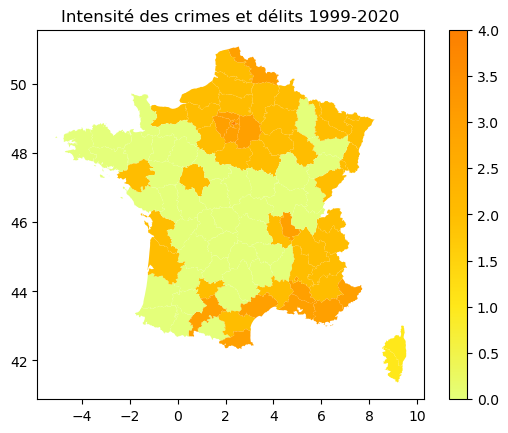

In [154]:
plt.figure(figsize=(12, 8))
vmin, vmax = gdf_departements['Cluster'].min(), gdf_departements['Cluster'].max()
gdf_departements.plot(column='Cluster', cmap='Wistia', legend=True, vmin=vmin, vmax=vmax)
plt.title("Intensité des crimes et délits 1999-2020")
plt.show()

In [164]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")
security_df['code_dep'] = security_df['code_dep'].astype(str)
security_df = security_df[~security_df['code_dep'].isin(col_a_supprimer)]
security_df = security_df[(security_df['annee'] >= 2000) & (security_df['annee'] <= 2005)]
security_df_selected_columns = security_df[['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population", "code_dep"]]
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()
donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']
feature_columns = ['PCA1', 'PCA2', 'PCA3']
X = resultats_pca_df[feature_columns].values
labels = tools.clustering(resultats_pca_df, ['PCA1', 'PCA2', 'PCA3'], 5)
resultats_pca_df['Cluster'] = labels
departements_geojson_name = 'departements.geojson'
gdf_departements = gpd.read_file(departements_geojson_name)
gdf_departements['Cluster'] = gdf_departements['code'].astype(str).map(resultats_pca_df.set_index('dept')['Cluster'])

In [165]:
print(resultats_pca_df.groupby('Cluster')['PCA1'].mean())

Cluster
0    -1.795171
1     0.313387
2    12.208431
3     1.121304
4     3.201322
Name: PCA1, dtype: float64


<Figure size 1200x800 with 0 Axes>

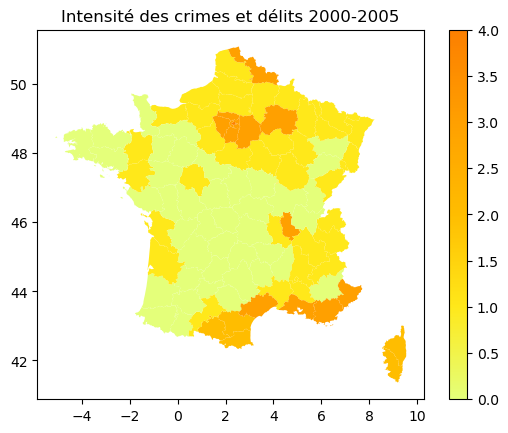

In [166]:
gdf_departements['Cluster'] = gdf_departements['Cluster'].replace({2: 4, 4:3, 3:2})

plt.figure(figsize=(12, 8))
vmin, vmax = gdf_departements['Cluster'].min(), gdf_departements['Cluster'].max()
gdf_departements.plot(column='Cluster', cmap='Wistia', legend=True, vmin=vmin, vmax=vmax)
plt.title("Intensité des crimes et délits 2000-2005")
plt.show()

In [167]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")
security_df['code_dep'] = security_df['code_dep'].astype(str)
security_df = security_df[~security_df['code_dep'].isin(col_a_supprimer)]
security_df = security_df[(security_df['annee'] >= 2015) & (security_df['annee'] <= 2020)]
security_df_selected_columns = security_df[['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population", "code_dep"]]
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()
donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']
feature_columns = ['PCA1', 'PCA2', 'PCA3']
X = resultats_pca_df[feature_columns].values
labels = tools.clustering(resultats_pca_df, ['PCA1', 'PCA2', 'PCA3'], 5)
resultats_pca_df['Cluster'] = labels
departements_geojson_name = 'departements.geojson'
gdf_departements = gpd.read_file(departements_geojson_name)
gdf_departements['Cluster'] = gdf_departements['code'].astype(str).map(resultats_pca_df.set_index('dept')['Cluster'])

In [168]:
print(resultats_pca_df.groupby('Cluster')['PCA1'].mean())

Cluster
0    -0.033329
1    10.607289
2    -1.593368
3     1.671427
4     1.329726
Name: PCA1, dtype: float64


<Figure size 1200x800 with 0 Axes>

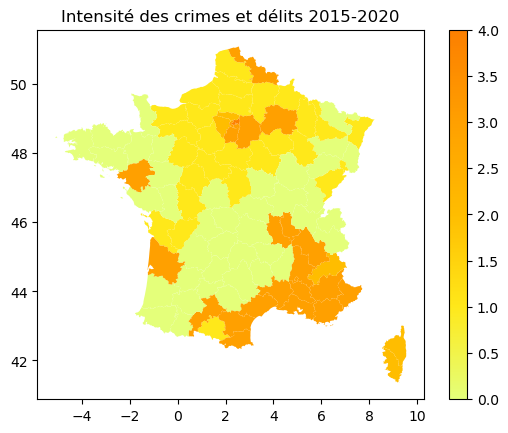

In [169]:
gdf_departements['Cluster'] = gdf_departements['Cluster'].replace({1:4, 4:2, 0:1, 2:0})
plt.figure(figsize=(12, 8))
vmin, vmax = gdf_departements['Cluster'].min(), gdf_departements['Cluster'].max()
gdf_departements.plot(column='Cluster', cmap='Wistia', legend=True, vmin=vmin, vmax=vmax)
plt.title("Intensité des crimes et délits 2015-2020")
plt.show()

In [178]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")
security_df['code_dep'] = security_df['code_dep'].astype(str)
security_df = security_df[~security_df['code_dep'].isin(col_a_supprimer)]
security_df = security_df[(security_df['annee'] >= 2010) & (security_df['annee'] <= 2015)]
security_df_selected_columns = security_df[['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population", "code_dep"]]
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()
donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']
feature_columns = ['PCA1', 'PCA2', 'PCA3']
X = resultats_pca_df[feature_columns].values
labels = tools.clustering(resultats_pca_df, ['PCA1', 'PCA2', 'PCA3'], 5)
resultats_pca_df['Cluster'] = labels
departements_geojson_name = 'departements.geojson'
gdf_departements = gpd.read_file(departements_geojson_name)
gdf_departements['Cluster'] = gdf_departements['code'].astype(str).map(resultats_pca_df.set_index('dept')['Cluster'])

In [179]:
print(resultats_pca_df.groupby('Cluster')['PCA1'].mean())

Cluster
0    -1.782501
1     3.238618
2    11.835681
3     0.334518
4     0.145210
Name: PCA1, dtype: float64


<Figure size 1200x800 with 0 Axes>

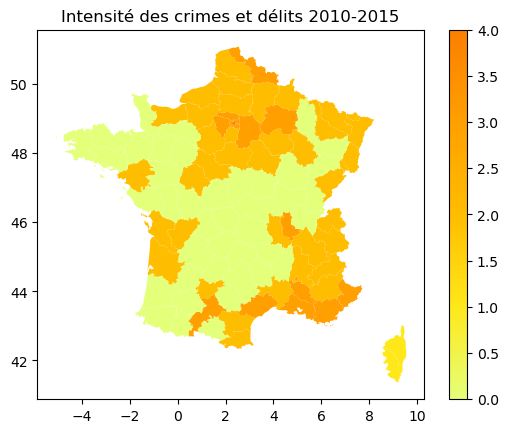

In [180]:
gdf_departements['Cluster'] = gdf_departements['Cluster'].replace({2:4, 1:3, 3:2, 4:1})
plt.figure(figsize=(12, 8))
vmin, vmax = gdf_departements['Cluster'].min(), gdf_departements['Cluster'].max()
gdf_departements.plot(column='Cluster', cmap='Wistia', legend=True, vmin=vmin, vmax=vmax)
plt.title("Intensité des crimes et délits 2010-2015")
plt.show()

In [173]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")
security_df['code_dep'] = security_df['code_dep'].astype(str)
security_df = security_df[~security_df['code_dep'].isin(col_a_supprimer)]
security_df = security_df[(security_df['annee'] >= 2005) & (security_df['annee'] <= 2010)]
security_df_selected_columns = security_df[['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population", "code_dep"]]
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()
donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']
feature_columns = ['PCA1', 'PCA2', 'PCA3']
X = resultats_pca_df[feature_columns].values
labels = tools.clustering(resultats_pca_df, ['PCA1', 'PCA2', 'PCA3'], 5)
resultats_pca_df['Cluster'] = labels
departements_geojson_name = 'departements.geojson'
gdf_departements = gpd.read_file(departements_geojson_name)
gdf_departements['Cluster'] = gdf_departements['code'].astype(str).map(resultats_pca_df.set_index('dept')['Cluster'])

In [174]:
print(resultats_pca_df.groupby('Cluster')['PCA1'].mean())

Cluster
0     0.142493
1     3.121785
2     1.121155
3    -1.861845
4    11.142439
Name: PCA1, dtype: float64


<Figure size 1200x800 with 0 Axes>

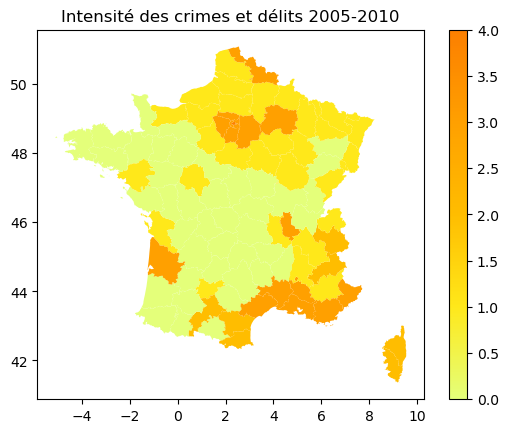

In [175]:
plt.figure(figsize=(12, 8))
gdf_departements['Cluster'] = gdf_departements['Cluster'].replace({1:3, 0:1, 3:0})
vmin, vmax = gdf_departements['Cluster'].min(), gdf_departements['Cluster'].max()
gdf_departements.plot(column='Cluster', cmap='Wistia', legend=True, vmin=vmin, vmax=vmax)
plt.title("Intensité des crimes et délits 2005-2010")
plt.show()